<a href="https://colab.research.google.com/github/ekaterinakuzmina/Projects/blob/master/customers_behaviour_kolonial_no.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [2]:
#@title Connect Colab with BigQuery
%%capture

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=cj8QA6TgiiNvQNmqXIJTkl20SWsc2W&code_challenge=pdVeAIGk94ok-Q8L_NwT0vMtyt_VsKnBV6i8Qond8MQ&prompt=consent&code_challenge_method=S256&access_type=offline

Enter verification code: ··········


In [0]:
#@title Import tools
%%capture

!pip install geopandas
!pip install fbprophet

import pandas as pd
import geopandas as gpd
from shapely import wkt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
sns.set()

# to upload files to the colab
from google.colab import files
import io

from scipy import stats

In [0]:
#@title Functions for the trend plots
%%capture

def plot_trend(df, date_col, value_col, name="", color="black", title="",
               width=1200, height=300):
    """
    Plot a single temporal trend.
    """
    df.sort_values(by=date_col, inplace=True)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
                    x = df[date_col],
                    y = df[value_col],
                    name = name,
                    line_color = color))

    # Use date string to set xaxis range
    fig.update_layout(
        title_text = title,
        width=width, 
        height=height
    )

    fig.show()  

def plot_trends(df, category_col, date_col, value_col, name="", colors=["black"], title="",
               width=1200, height=300, yaxis_type="linear"):
    """
    Plot a series of temporal trends.
    """
    df.sort_values(by=date_col, inplace=True)
    
    fig = go.Figure()
    
    ix = 0
    for cat, cat_df in df.groupby(category_col):

        color = dict(enumerate(colors)).get(ix, "black")
        
        fig.add_trace(go.Scatter(
                        x = cat_df[date_col],
                        y = cat_df[value_col],
                        name = cat,
                        line_color = color))
        ix += 1

    # Use date string to set xaxis range
    fig.update_layout(
        title_text = title,
        width=width, 
        height=height,
        yaxis_type=yaxis_type
    )

    #fig.update_layout(xaxis_type="log", yaxis_type="log")

    fig.show()  

In [0]:
#@title Upload `order_lines` to BigQuery
%%capture

# divide order_lines into 4 parts
order_lines_part1 = order_lines[0:65572]
order_lines_part1.to_csv('order_lines_part1.csv')
#!cp data.csv '/content/gdrive'

order_lines_part2 = order_lines[65572:131144]
order_lines_part2.to_csv('order_lines_part2.csv')
#!cp data.csv "drive/My Drive/"

order_lines_part3 = order_lines[131144:196716]
order_lines_part3.to_csv('order_lines_part3.csv')
#!cp data.csv "drive/My Drive/"

order_lines_part4 = order_lines[196716:]
order_lines_part4.to_csv('order_lines_part4.csv')

files.download("order_lines_part1.csv")
files.download("order_lines_part2.csv")
files.download("order_lines_part3.csv")
files.download("order_lines_part4.csv")

"""
CREATE OR REPLACE TABLE `customers-behaviour.data.order_lines` AS

SELECT
* except (int64_field_0)
FROM
`customers-behaviour.data.order_lines_part1` 

UNION ALL

SELECT
* except (int64_field_0)
FROM
`customers-behaviour.data.order_lines_part2` 

UNION ALL

SELECT
* except (int64_field_0)
FROM
`customers-behaviour.data.order_lines_part3` 

UNION ALL

SELECT
* except (int64_field_0)
FROM
`customers-behaviour.data.order_lines_part4` 
"""

In [0]:
#@title Upload `zip_places` to BigQuery
%%capture

CREATE OR REPLACE TABLE `customers-behaviour.data.zip_places` AS

SELECT 
string_field_0	AS zip_place, 
string_field_1 AS municipality, 
string_field_2	AS county
FROM 
`customers-behaviour.data.zip_places` 
WHERE
string_field_0 != "zip_place"
ORDER BY 
string_field_0

In [0]:
#@title Upload polygons for counties (fylker)
%%capture

uploaded_geojson = files.upload()
counties_2018 = gpd.read_file("fylker_18.geojson")

In [0]:
#@title Upload polygons for municipalities (kommuner)
%%capture

uploaded_geojson = files.upload()
municipalities_2018 = gpd.read_file("kommuner_18.geojson")

# **GOAL 1: Explore how SEASONALITY influences ...**

## 1. **... total number of orders made by all users per day**

*Hypothesis*:  Seasonality (weekdays, seasons) influences the total number of orders.



In [0]:
#@title Query to get counts of daily unique orders

%%bigquery --project customers-behaviour customer_id_count

SELECT 
  delivery_date,
  FORMAT_DATE("%A", delivery_date) as weekday,
  FORMAT_DATE("%m", delivery_date) as month,
  CASE 
  WHEN FORMAT_DATE("%m", delivery_date) IN ("01", "02", "12") THEN "WINTER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("03", "04", "05") THEN "SPRING"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("06", "07", "08") THEN "SUMMER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("09", "10", "11") THEN "FALL"
  END AS season,
  CASE 
  WHEN EXTRACT(DAYOFWEEK from delivery_date) IN (1, 7) THEN "weekend"
  ELSE "working day"
  END AS working_day,
  COUNT(DISTINCT order_id) AS count_order_id
FROM 
  `customers-behaviour.data.order_lines`
GROUP BY
  delivery_date
ORDER BY 
 delivery_date

In [170]:
#@title Total number of orders by **day**
plot_trend(customer_id_count, 'delivery_date', 'count_order_id', width=2000, height=800, color="orange")

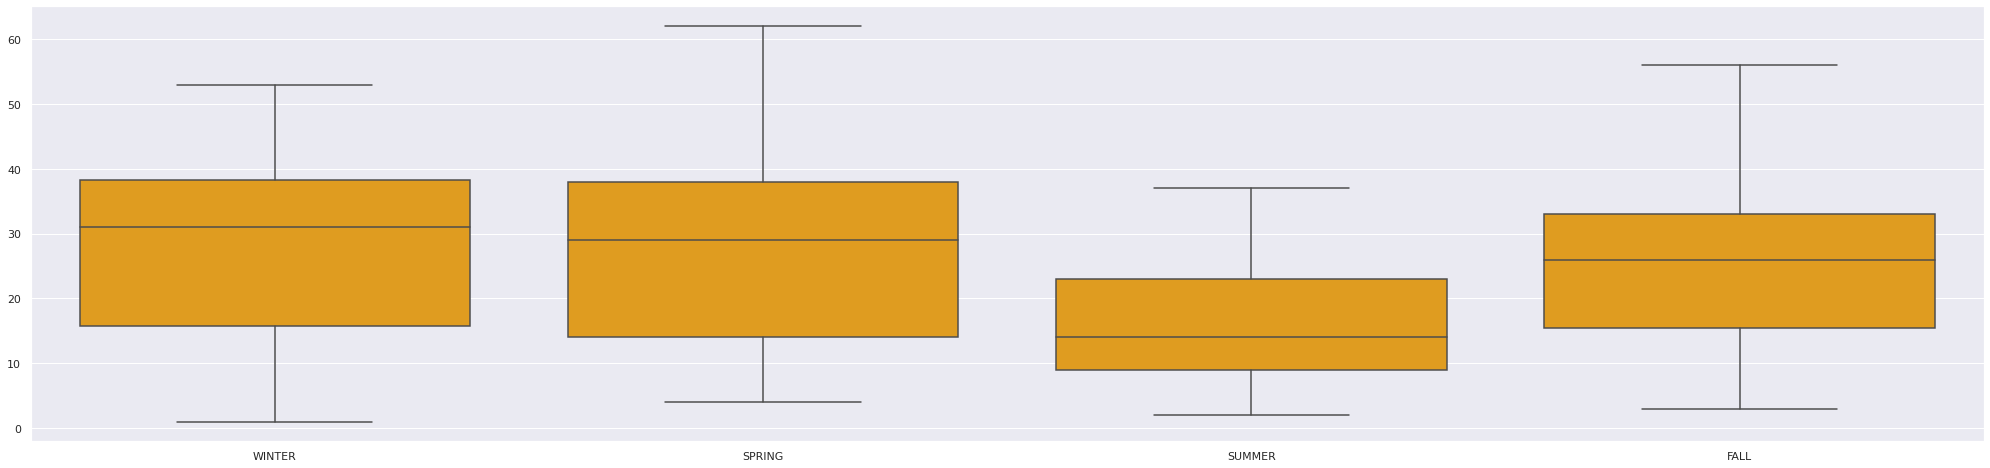

In [402]:
#@title Total number of orders by **season**
sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="season", y="count_order_id", data=customer_id_count, order=["WINTER", "SPRING", "SUMMER", "FALL"], color = "orange")
plt.xlabel('')
plt.ylabel('')
plt.show()

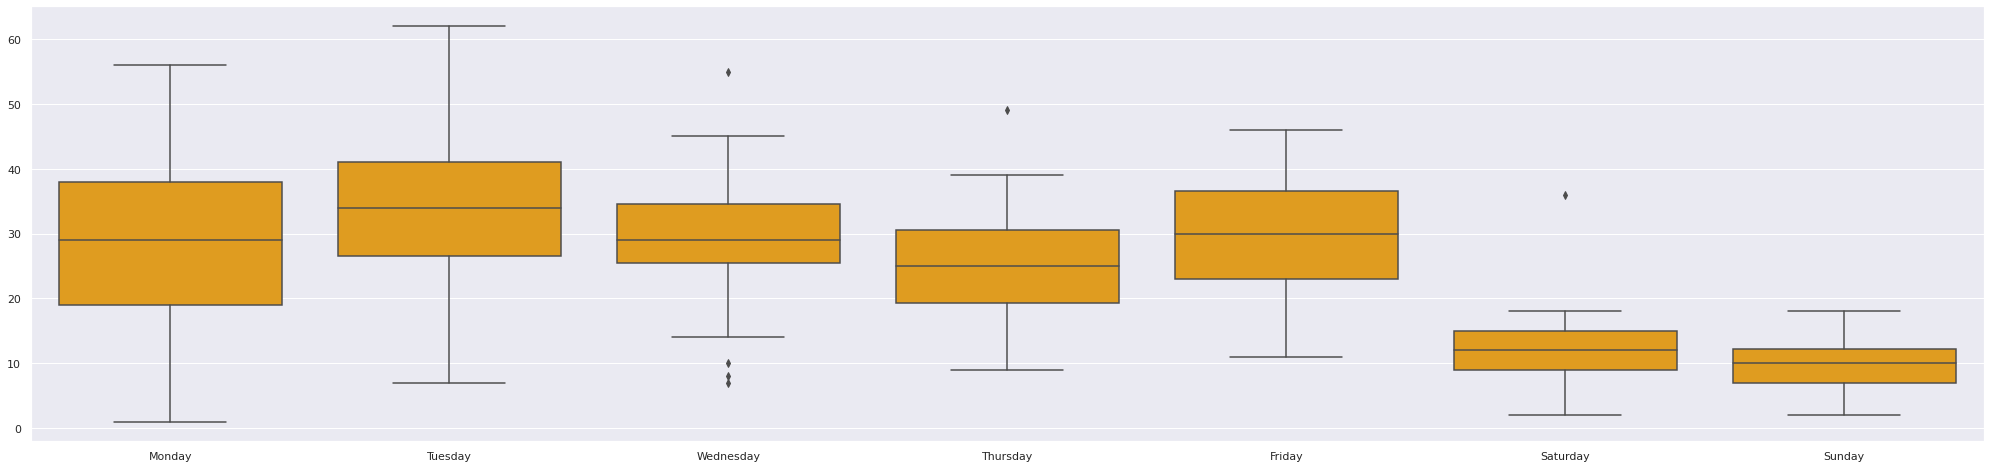

In [403]:
#@title Total number of orders by **weekday**
sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="weekday", y="count_order_id", data=customer_id_count, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], color = "orange")
plt.xlabel('')
plt.ylabel('')
plt.show()

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- Customers order significanlty less on weekends compared to working days. This can be a result of customer´s behaviour or, on the other hand, a result of a smaller delivering capacity offered by Kolonial on weekends.

- Customers order significantly less in summer compared to other seasons.

#### *Are there any patterns you feel would be worth investigating further?*

- To check whether there is reduced delivering capacity during OR decreased demand on weekends.

#### *How do you recommend to grow our revenue?*

- If the delivering capacity is the problem: increase it.

- If the demand is lower: decrease spend on the delivering capacity. 


## 2. **... how much users spend per order on average**

*Hypothesis:* Average spend per order is not influenced by seasonality. 


In [0]:
#@title Query to get average costs for orders for each day

%%bigquery --project customers-behaviour daily_avg_spend

WITH base as(
SELECT 
  delivery_date,
  order_id,
  SUM(net_unit_price*quantity)	AS spend
FROM 
  `customers-behaviour.data.order_lines`
GROUP BY
  order_id,
  delivery_date
ORDER BY
  delivery_date)
  
SELECT
  delivery_date, 
  FORMAT_DATE("%A", delivery_date) as weekday,
    CASE 
  WHEN FORMAT_DATE("%m", delivery_date) IN ("01", "02", "12") THEN "WINTER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("03", "04", "05") THEN "SPRING"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("06", "07", "08") THEN "SUMMER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("09", "10", "11") THEN "FALL"
  END AS season,
  CASE 
  WHEN EXTRACT(DAYOFWEEK from delivery_date) IN (1, 7) THEN "weekend"
  ELSE "working day"
  END AS working_day,
  ROUND(AVG(spend), 1) AS daily_average_spend
FROM  
  base
GROUP BY
  delivery_date
ORDER BY 
  delivery_date

In [360]:
#@title Average daily spend per order by **day**
plot_trend(daily_avg_spend, 'delivery_date', 'daily_average_spend', width=2000, height=800, color="orange")

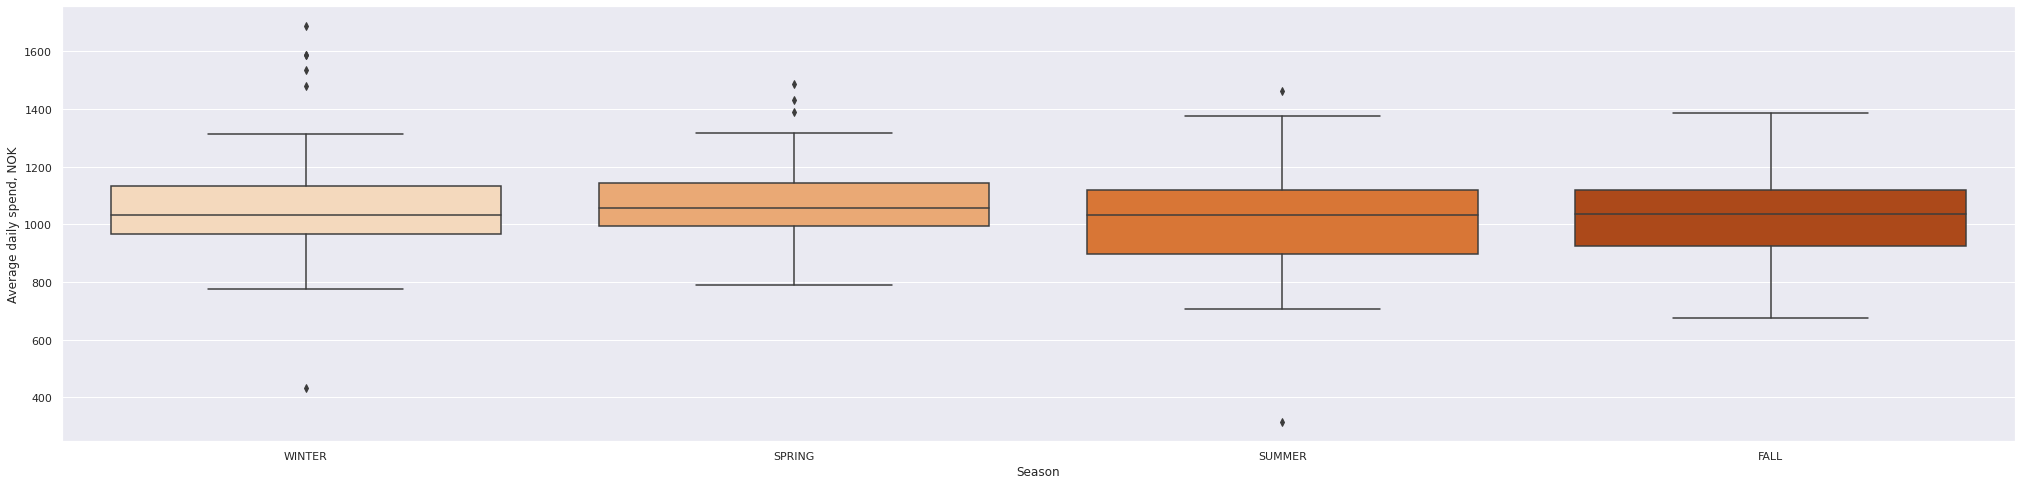

In [363]:
#@title Average daily spend by **season**
sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="season", y="daily_average_spend", data=daily_avg_spend, order=["WINTER", "SPRING", "SUMMER", "FALL"], palette="Oranges")
plt.xlabel('Season')
plt.ylabel('Average daily spend, NOK')
plt.show()

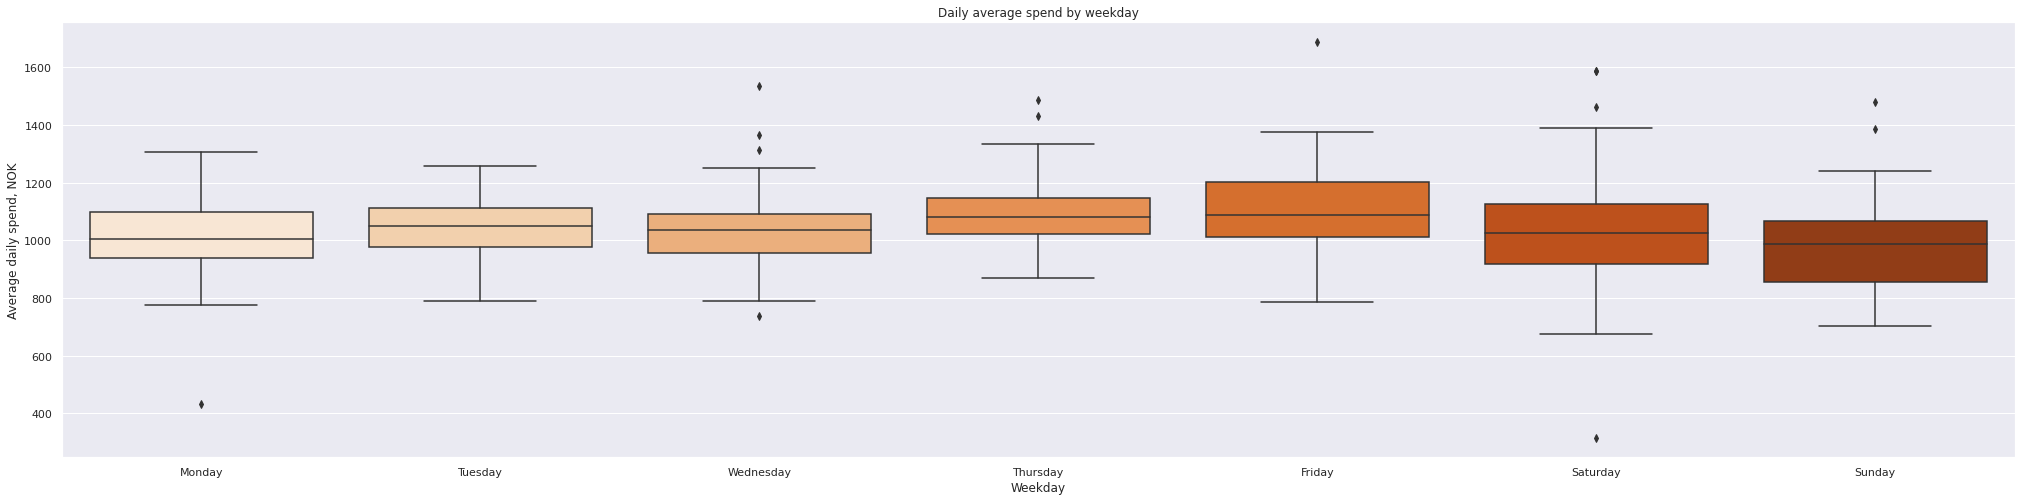

In [362]:
#@title Average daily spend by **weekday**

sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="weekday", y="daily_average_spend", data=daily_avg_spend, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], palette="Oranges")
plt.title('Daily average spend by weekday')
plt.xlabel('Weekday')
plt.ylabel('Average daily spend, NOK')
plt.show()

In [364]:
daily_avg_spend.daily_average_spend.describe()

count     359.000000
mean     1042.730641
std       159.505924
min       316.600000
25%       949.800000
50%      1038.100000
75%      1125.650000
max      1687.400000
Name: daily_average_spend, dtype: float64

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- The average amount of money customers spend per order is relatively independent of seasonality. On average, they spend **1038 NOK** per order. 


#### *Are there any patterns you feel would be worth investigating further?*

- No.

## 3. **... whether users pick up orders or ask for delivery**

*Hypothesis 1*: Customers would ask for delivery more in winter compared to other seasons.  

*Hypothesis 2*: Customers would ask for delivery more during working days comapred to weekends.

In [0]:
#@title Query to get counts of how many orders were delivered or picked up for each day

%%bigquery --project customers-behaviour picked_delivered

WITH base AS (

SELECT
  order_id, 
  ANY_VALUE(customer_id) AS customer_id, 
  delivery_date, 
  ANY_VALUE(is_delivery) AS is_delivery, 
  ANY_VALUE(zip_place) AS zip_place, 
  SUM(net_unit_price*quantity) AS daily_spend, 
  ANY_VALUE(is_from_recipe) AS is_from_recipe, 
  ANY_VALUE(is_from_product_list) AS is_from_product_list, 
FROM
  `customers-behaviour.data.order_lines`
GROUP BY
  order_id, 
  delivery_date
ORDER BY 
delivery_date), 

very_last AS (

SELECT 
  delivery_date,
  FORMAT_DATE("%A", delivery_date) as weekday,
  CASE 
  WHEN FORMAT_DATE("%m", delivery_date) IN ("01", "02", "12") THEN "WINTER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("03", "04", "05") THEN "SPRING"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("06", "07", "08") THEN "SUMMER"
  WHEN FORMAT_DATE("%m", delivery_date) IN ("09", "10", "11") THEN "FALL"
  END AS season,
  CASE
  WHEN is_delivery = true THEN "delivered"
  WHEN is_delivery = false THEN "picked up"
  END AS is_delivery,
  COUNT(*) AS order_cnt, 
  SUM(COUNT(*)) OVER (PARTITION BY delivery_date) AS total_order_cnt
FROM 
  base
GROUP BY
  delivery_date, 
  is_delivery)
 
SELECT
  delivery_date, 
  weekday, 
  season, 
  is_delivery, 
  order_cnt, 
  total_order_cnt, 
  CAST(order_cnt*100/total_order_cnt AS INT64) AS order_perc
FROM
  very_last
WHERE
  is_delivery = "delivered"
ORDER BY
  delivery_date

In [13]:
#@title Total number of orders picked up or delivered by **day**

plot_trend(picked_delivered, 'delivery_date', 'order_perc', width=2000, height=800, color="orange")

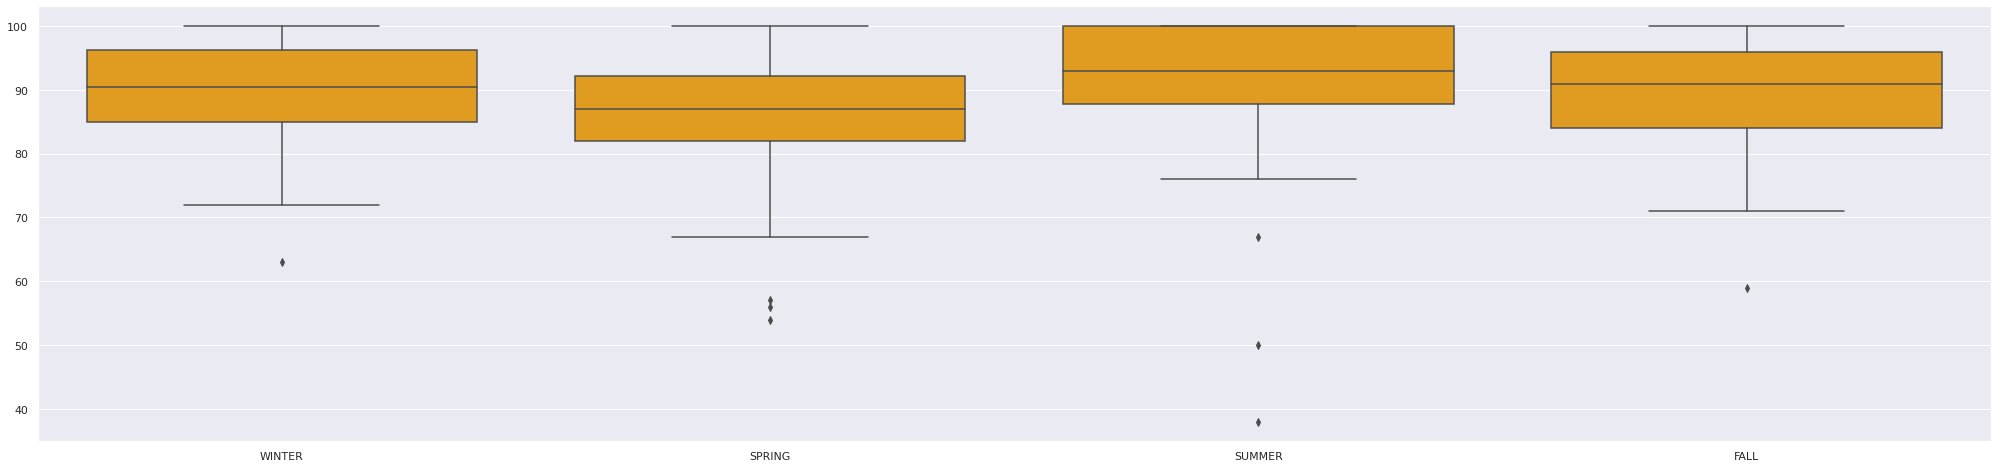

In [15]:
#@title Total number of orders picked up or delivered by **season**
sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="season", y="order_perc", data=picked_delivered, order=["WINTER", "SPRING", "SUMMER", "FALL"], color="orange")
plt.xlabel('')
plt.ylabel('')
plt.show()

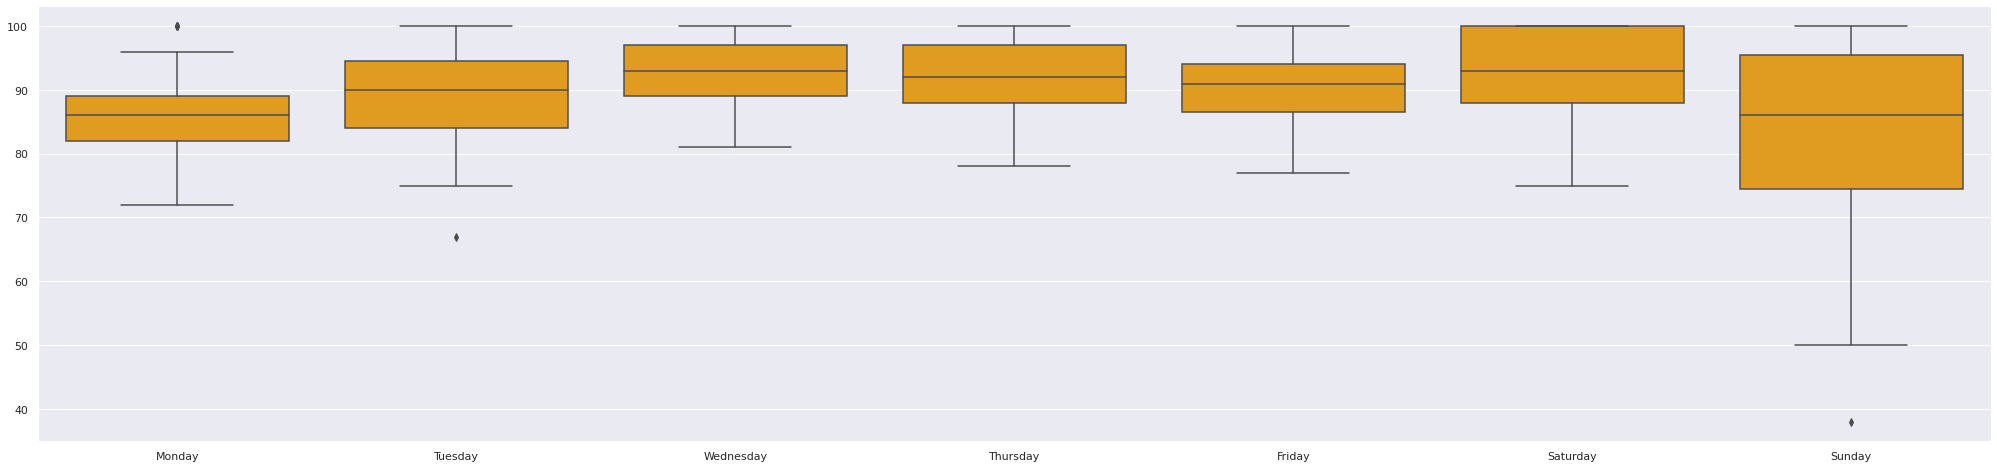

In [18]:
#@title Total number of orders picked up or delivered by **weekday**

sns.set(rc={'figure.figsize':(35,8)})
g = sns.boxplot(x="weekday", y="order_perc", data=picked_delivered, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], color="orange")
plt.xlabel('')
plt.ylabel('')
plt.show()

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- Seasonality does not influence the percentage of delivered orders.

#### *Are there any patterns you feel would be worth investigating further?*

- No

#### *How do you recommend to grow our revenue?*

- In summer there is a slightly higher percentage of delivered orders, the delivery can be done by bicycles in relevant cases. 


## 4. **... what type of products users order**

In [0]:
#@title Query to get counts of how many products of a specific category were delivered on each day 

%%bigquery --project customers-behaviour category_by_day

WITH base AS (

SELECT
  product_id, 
  quantity,
  product_name,
  main_category,
  sub_category,
  brand,
  delivery_date,
  is_delivery, 
FROM
  `customers-behaviour.data.order_lines`
LEFT JOIN
  `customers-behaviour.data.products`
USING 
  (product_id)
ORDER BY 
  product_id, 
  delivery_date)

SELECT
  delivery_date, 
  main_category, 
  SUM(quantity) as count
FROM
  base
GROUP BY 
  delivery_date, 
  main_category
HAVING 
  main_category IS NOT NULL
ORDER BY
  delivery_date, 
  count DESC

In [33]:
#@title Number of products of each category by **day**

plot_trends(category_by_day, 'main_category', 'delivery_date', 'count', width=2500, height=800,)

In [0]:
#@title Query to get counts of how many products of a specific category were delivered during the year

%%bigquery --project customers-behaviour category_year

WITH base AS (

SELECT
  product_id, 
  quantity,
  product_name,
  main_category,
  sub_category,
  brand,
  delivery_date,
  is_delivery, 
FROM
  `customers-behaviour.data.order_lines`
LEFT JOIN
  `customers-behaviour.data.products`
USING 
  (product_id)
ORDER BY 
  product_id, delivery_date)

SELECT
  main_category, 
  SUM(quantity) as count
FROM
  base
GROUP BY 
  main_category
HAVING 
  main_category IS NOT NULL
ORDER BY
  count DESC
LIMIT 10

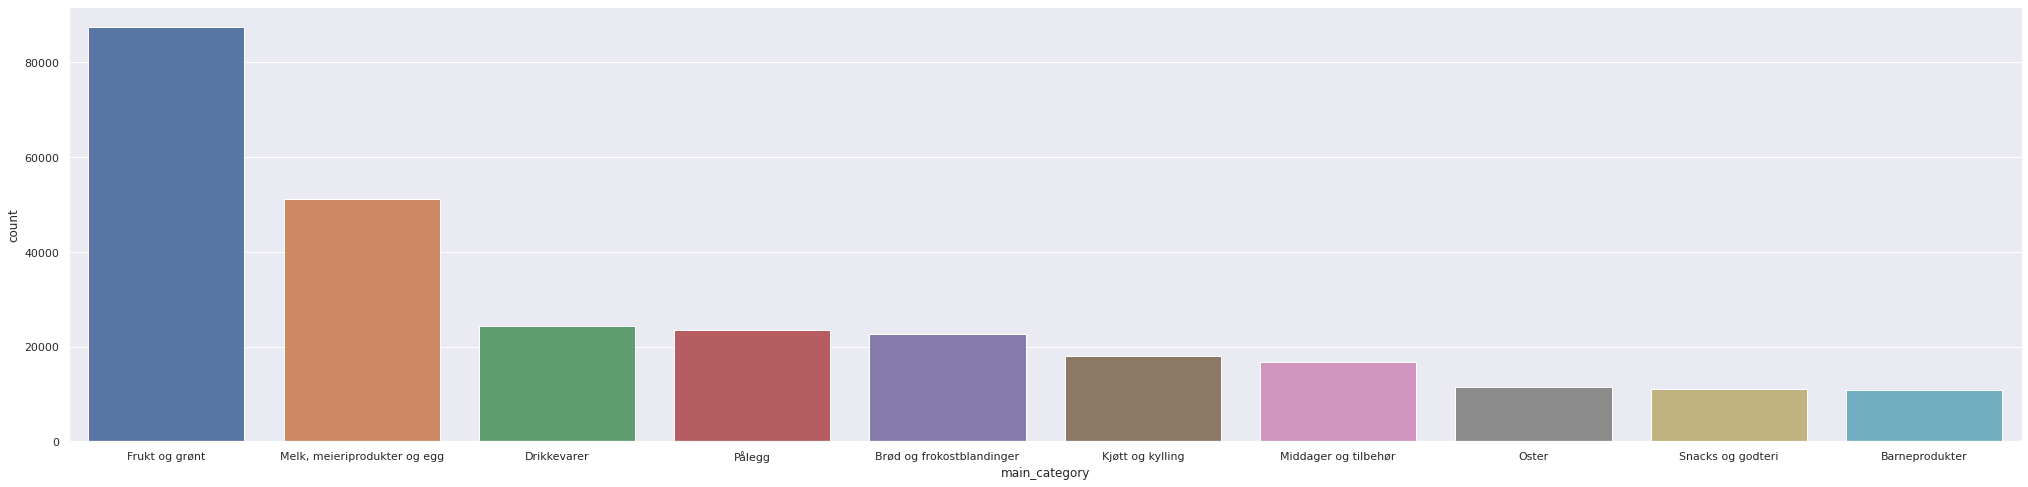

In [32]:
#@title Top 10 categories by number of sold products per year

sns.set(rc={'figure.figsize':(35,8)})
sns.barplot(x="main_category", y="count", data=category_year)
plt.show()

### **Conclusions:**


#### *How do you recommend to grow our revenue?*

- Based on the daily trends for each category, control supply and adjust newsletters.


# **GOAL 2: Explore USER CHARACTERISTICS**



## 1. **How are user characteristics distributed in the sample** 


In [0]:
#@title Query to get characteristics of the users

%%bigquery --project customers-behaviour users

SELECT 
  customer_id, 
  DATE_DIFF(DATE '2019-01-01', birth_date, YEAR) AS age,
  subscribed_to_newsletter, 
  signed_up_from_channel
FROM 
  `customers-behaviour.data.customers`

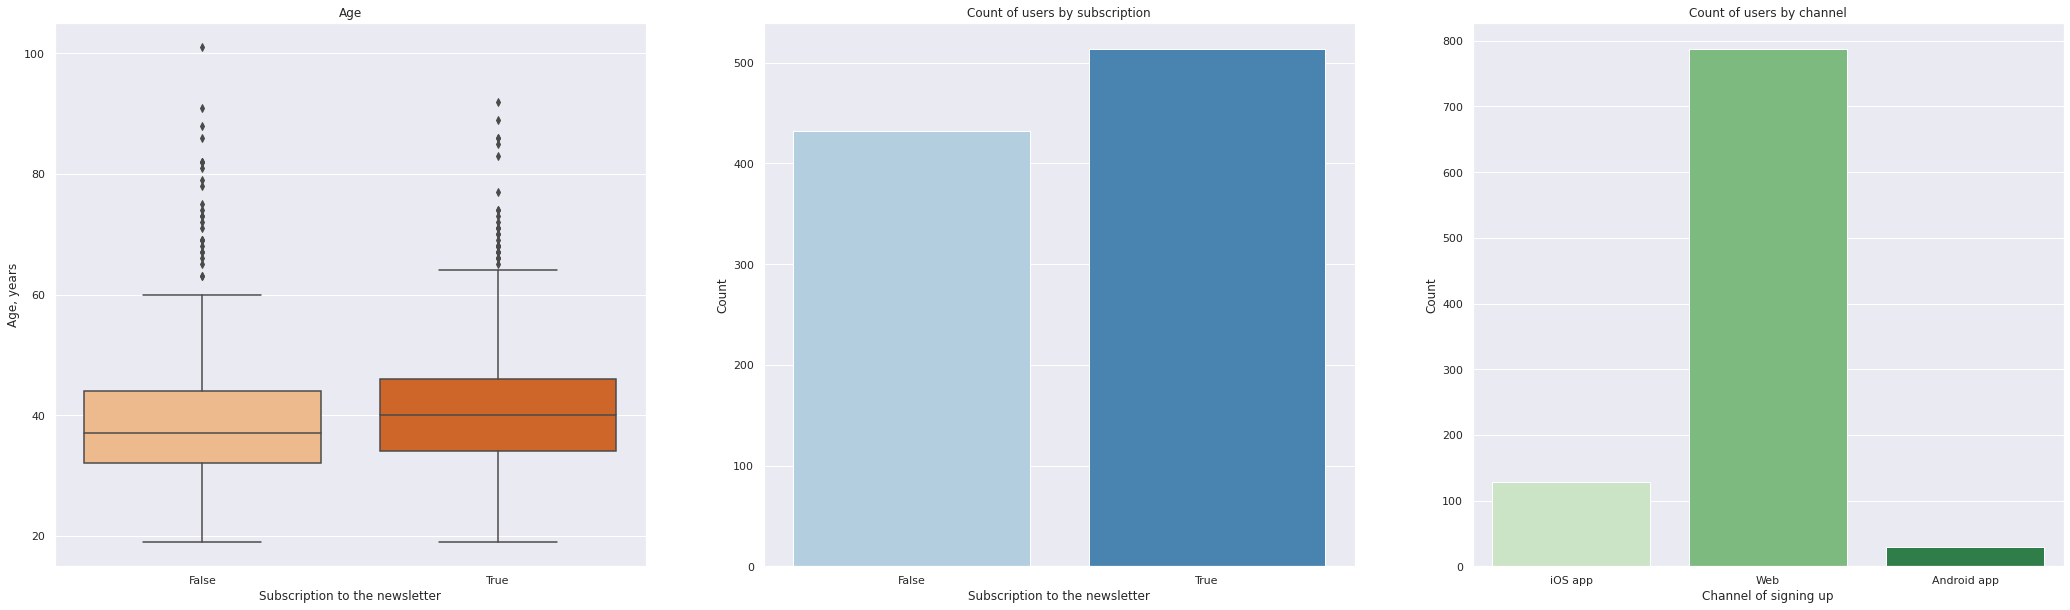

In [299]:
#@title  Here are general characteristics of the users
sns.set(rc={'figure.figsize':(36,10)})
fig, axs = plt.subplots(ncols=3)
sns.boxplot(x="subscribed_to_newsletter", y="age", data=users, palette="Oranges", ax=axs[0]).set(xlabel='Subscription to the newsletter', ylabel='Age, years', title = "Age")
sns.countplot(x="subscribed_to_newsletter", data=users,  palette="Blues",  ax=axs[1]).set(xlabel='Subscription to the newsletter', ylabel='Count', title = "Count of users by subscription")
sns.countplot(x="signed_up_from_channel", data=users,  palette="Greens", ax=axs[2]).set(xlabel='Channel of signing up', ylabel='Count', title = "Count of users by channel")
plt.show()


In [391]:
users.age.describe()

count    946.000000
mean      40.593023
std       12.007595
min       19.000000
25%       33.000000
50%       38.000000
75%       45.000000
max      101.000000
Name: age, dtype: float64

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- The average age is **38** varying from **19** to **101**, 50% of the customers are between 33 and 45 years old

- Age does not affect whether customers subscribe to the newsletter.

- The number of users who subscribed and who didi not is relatively the same: **54%** are subscribed to the newsletter and **46%** are not.

- The great majority of the users signed up from the website, not from the mobile apps: in the sample, **83%** subscribed from the website, **14%** - from the iOS app, and **3%** from Android app


#### *Are there any patterns you feel would be worth investigating further?*

- There are no clear patterns attracting attention.

#### *How do you recommend to grow our revenue?*

- To come up with strategies on targeting older population.

## 2. **How does subscription to the newsletter and channel of signing up influence total spend users make per year?**

*Hypotheses 1*: Customers who are subscribed to the newsletter spend more per year than those who are not subscribed.

*Hypotheses 2*: Customers signed up from iOS might pay more than those who signed up from Android. 

In [0]:
#@title Hidden SQL: Main query

%%bigquery --project customers-behaviour customers_orders

WITH base AS(
SELECT
  order_id,
  customer_id, 
  ANY_VALUE(delivery_date) AS delivery_date,
  ANY_VALUE(is_delivery) AS is_delivery, 
  ANY_VALUE(zip_place) AS zip_place, 
  SUM(net_unit_price*quantity) AS order_cost, 
  ANY_VALUE(is_from_recipe) AS is_from_recipe, 
  ANY_VALUE(is_from_product_list) AS is_from_product_list, 
FROM
  `customers-behaviour.data.order_lines`
GROUP BY
  order_id, 
  customer_id)
  
SELECT
  customer_id, 
  DATE_DIFF(DATE '2019-01-01', ANY_VALUE(birth_date), YEAR) AS age,
  ANY_VALUE(subscribed_to_newsletter) AS subscribed_to_newsletter, 
  ANY_VALUE(signed_up_from_channel) AS signed_up_from_channel,
  COUNT(*) AS order_cnt, 
  ROUND(SUM(order_cost), 2) AS total_spend, 
  ROUND(AVG(order_cost), 2) AS avg_order_spend, 
FROM
  base
LEFT JOIN 
  `customers-behaviour.data.customers`
USING 
  (customer_id)
GROUP BY
  customer_id

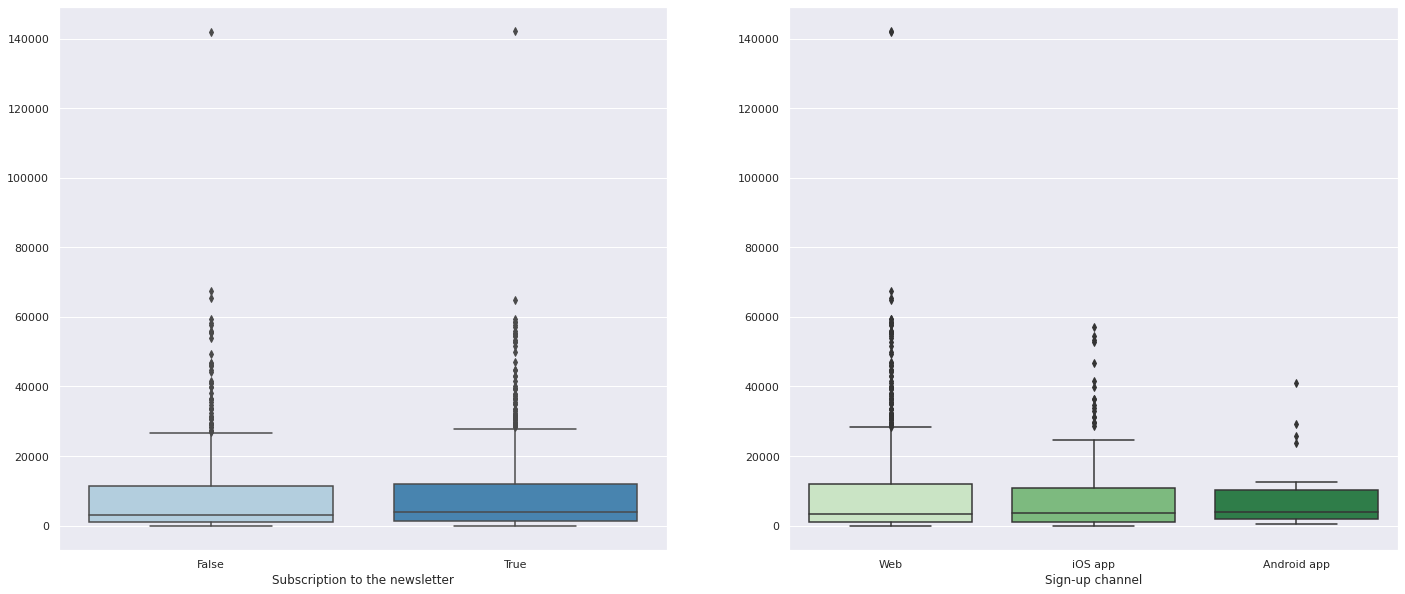

In [37]:
#@title  Total spend per year by subscription to the newsletter and sign-up channel

sns.set(rc={'figure.figsize':(24,10)})
fig, axs = plt.subplots(ncols=2)
sns.boxplot(x="subscribed_to_newsletter", y="total_spend", data=customers_orders, palette="Blues", ax=axs[0]).set(xlabel='Subscription to the newsletter', ylabel='')
sns.boxplot(x="signed_up_from_channel", y="total_spend", data=customers_orders, palette="Greens", ax=axs[1]).set(xlabel = 'Sign-up channel', ylabel = "")
plt.show()

In [38]:
customers_orders.total_spend.describe()

count       946.000000
mean       9591.617537
std       14309.399771
min          22.780000
25%        1139.835000
50%        3402.045000
75%       11819.962500
max      142057.750000
Name: total_spend, dtype: float64

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- The average total spend per year is **3 402 NOK**, varying from **22 NOK** to **142 057 NOK**.

- Subscription to the newsletter does not influence total spend per year. 

- Sign-up channel does not influence total spend per year. 

#### *Are there any patterns you feel would be worth investigating further?*

- The absence of more senior customers in the sample.

- The absence of the difference in total spend between those who are subscribed and those who are not: probably can lead to the cocnlusion that the newsletter is not effective.

- The smaller number of customers signed up from mobile apps: might indicate the need to explore how user-friendly mobile versions of the websites are.

#### *How do you recommend to grow our revenue?*

- Develope strategies for recruiting more senior people.

- Investiagte further the role of the newsletter and probably adjust it to customers´needs.

- Investigate how to make the sign up from the mobile devices easier. 

## 3. **What is a relationship between age and total spend?**

*Hypothesis*: Older people would have greater total spend.  



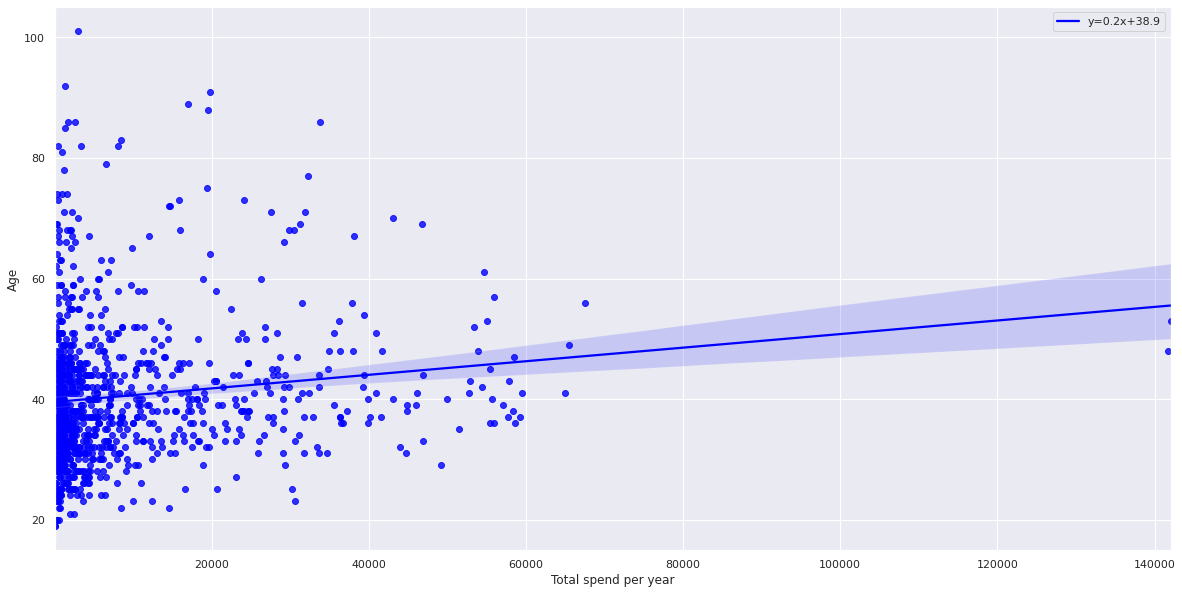

In [39]:
#@title  Relationship between customers´ age and their total spend per year
fig = plt.figure(figsize=(20,10))
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(customers_orders['order_cnt'],customers_orders['age'])


# use line_kws to set line label for legend
ax = sns.regplot(x="total_spend", y="age", 
                 data=customers_orders, 
                 color='blue', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

ax.set(xlabel='Total spend per year', ylabel='Age')

# plot legend
ax.legend()
plt.show()

In [40]:
 #@title  Spearman´s correlation coefficeint is ...
 round(customers_orders[["age", "total_spend"]].corr(method='spearman'), 2)

age  total_spend
age          1.00         0.17
total_spend  0.17         1.00

### **Conclusions:**

#### *What does customer’s shopping behaviour look like?*

- The relationship between customers´age and total spend is positive with a weak effect size.  

#### *Are there any patterns you feel would be worth investigating further?*

- Age does not seem to be an imporatnt feature for how much customers spend per year. However, if the customer base grows and include more senior people, this should be revisited. 

#### *How do you recommend to grow our revenue?*

- There is a weak positive trend towards older people spending more per year that contributes to the suggestion to include more senior people into the customers base.

# **GOAL 3: Explore how LOCATION influences ...**

## 1. **... total spend on the county level** during one year

In [0]:
#@title Query to get total spend for each county

%%bigquery --project customers-behaviour county

WITH 

orders AS (
  SELECT 
    order_id, 
    ANY_VALUE(zip_place) AS zip_place, 
    CAST(SUM(quantity*net_unit_price) AS INT64) AS order_total_spend
  FROM
    `customers-behaviour.data.order_lines`
  GROUP BY
    order_id), 

metrics_zip_place AS (
  SELECT
    zip_place, 
    ANY_VALUE(municipality) AS municipality, 
    ANY_VALUE(county) AS county,
    SUM(order_total_spend) AS total_spend
  FROM
    orders
  LEFT JOIN
    `customers-behaviour.data.zip_places`
  USING 
    (zip_place)
  GROUP BY
    zip_place)

SELECT
  county AS navn,
  SUM(order_count) AS order_count, 
  CAST(SUM(total_spend) AS INT64) AS total_spend
FROM
  metrics_zip_place
GROUP BY 
  county
ORDER BY 
  total_spend DESC

In [238]:
#@title  Counties based on their total spend per year
pd.set_option('display.max_rows', 2000)
county

navn  order_count  total_spend
0  Akershus        34121     35701991
1   Østfold          338       306189
2  Buskerud          174       228343
3   Hedmark          212       199704
4  Telemark          103       117455
5  Vestfold           83       110845
6   Oppland           45        42065

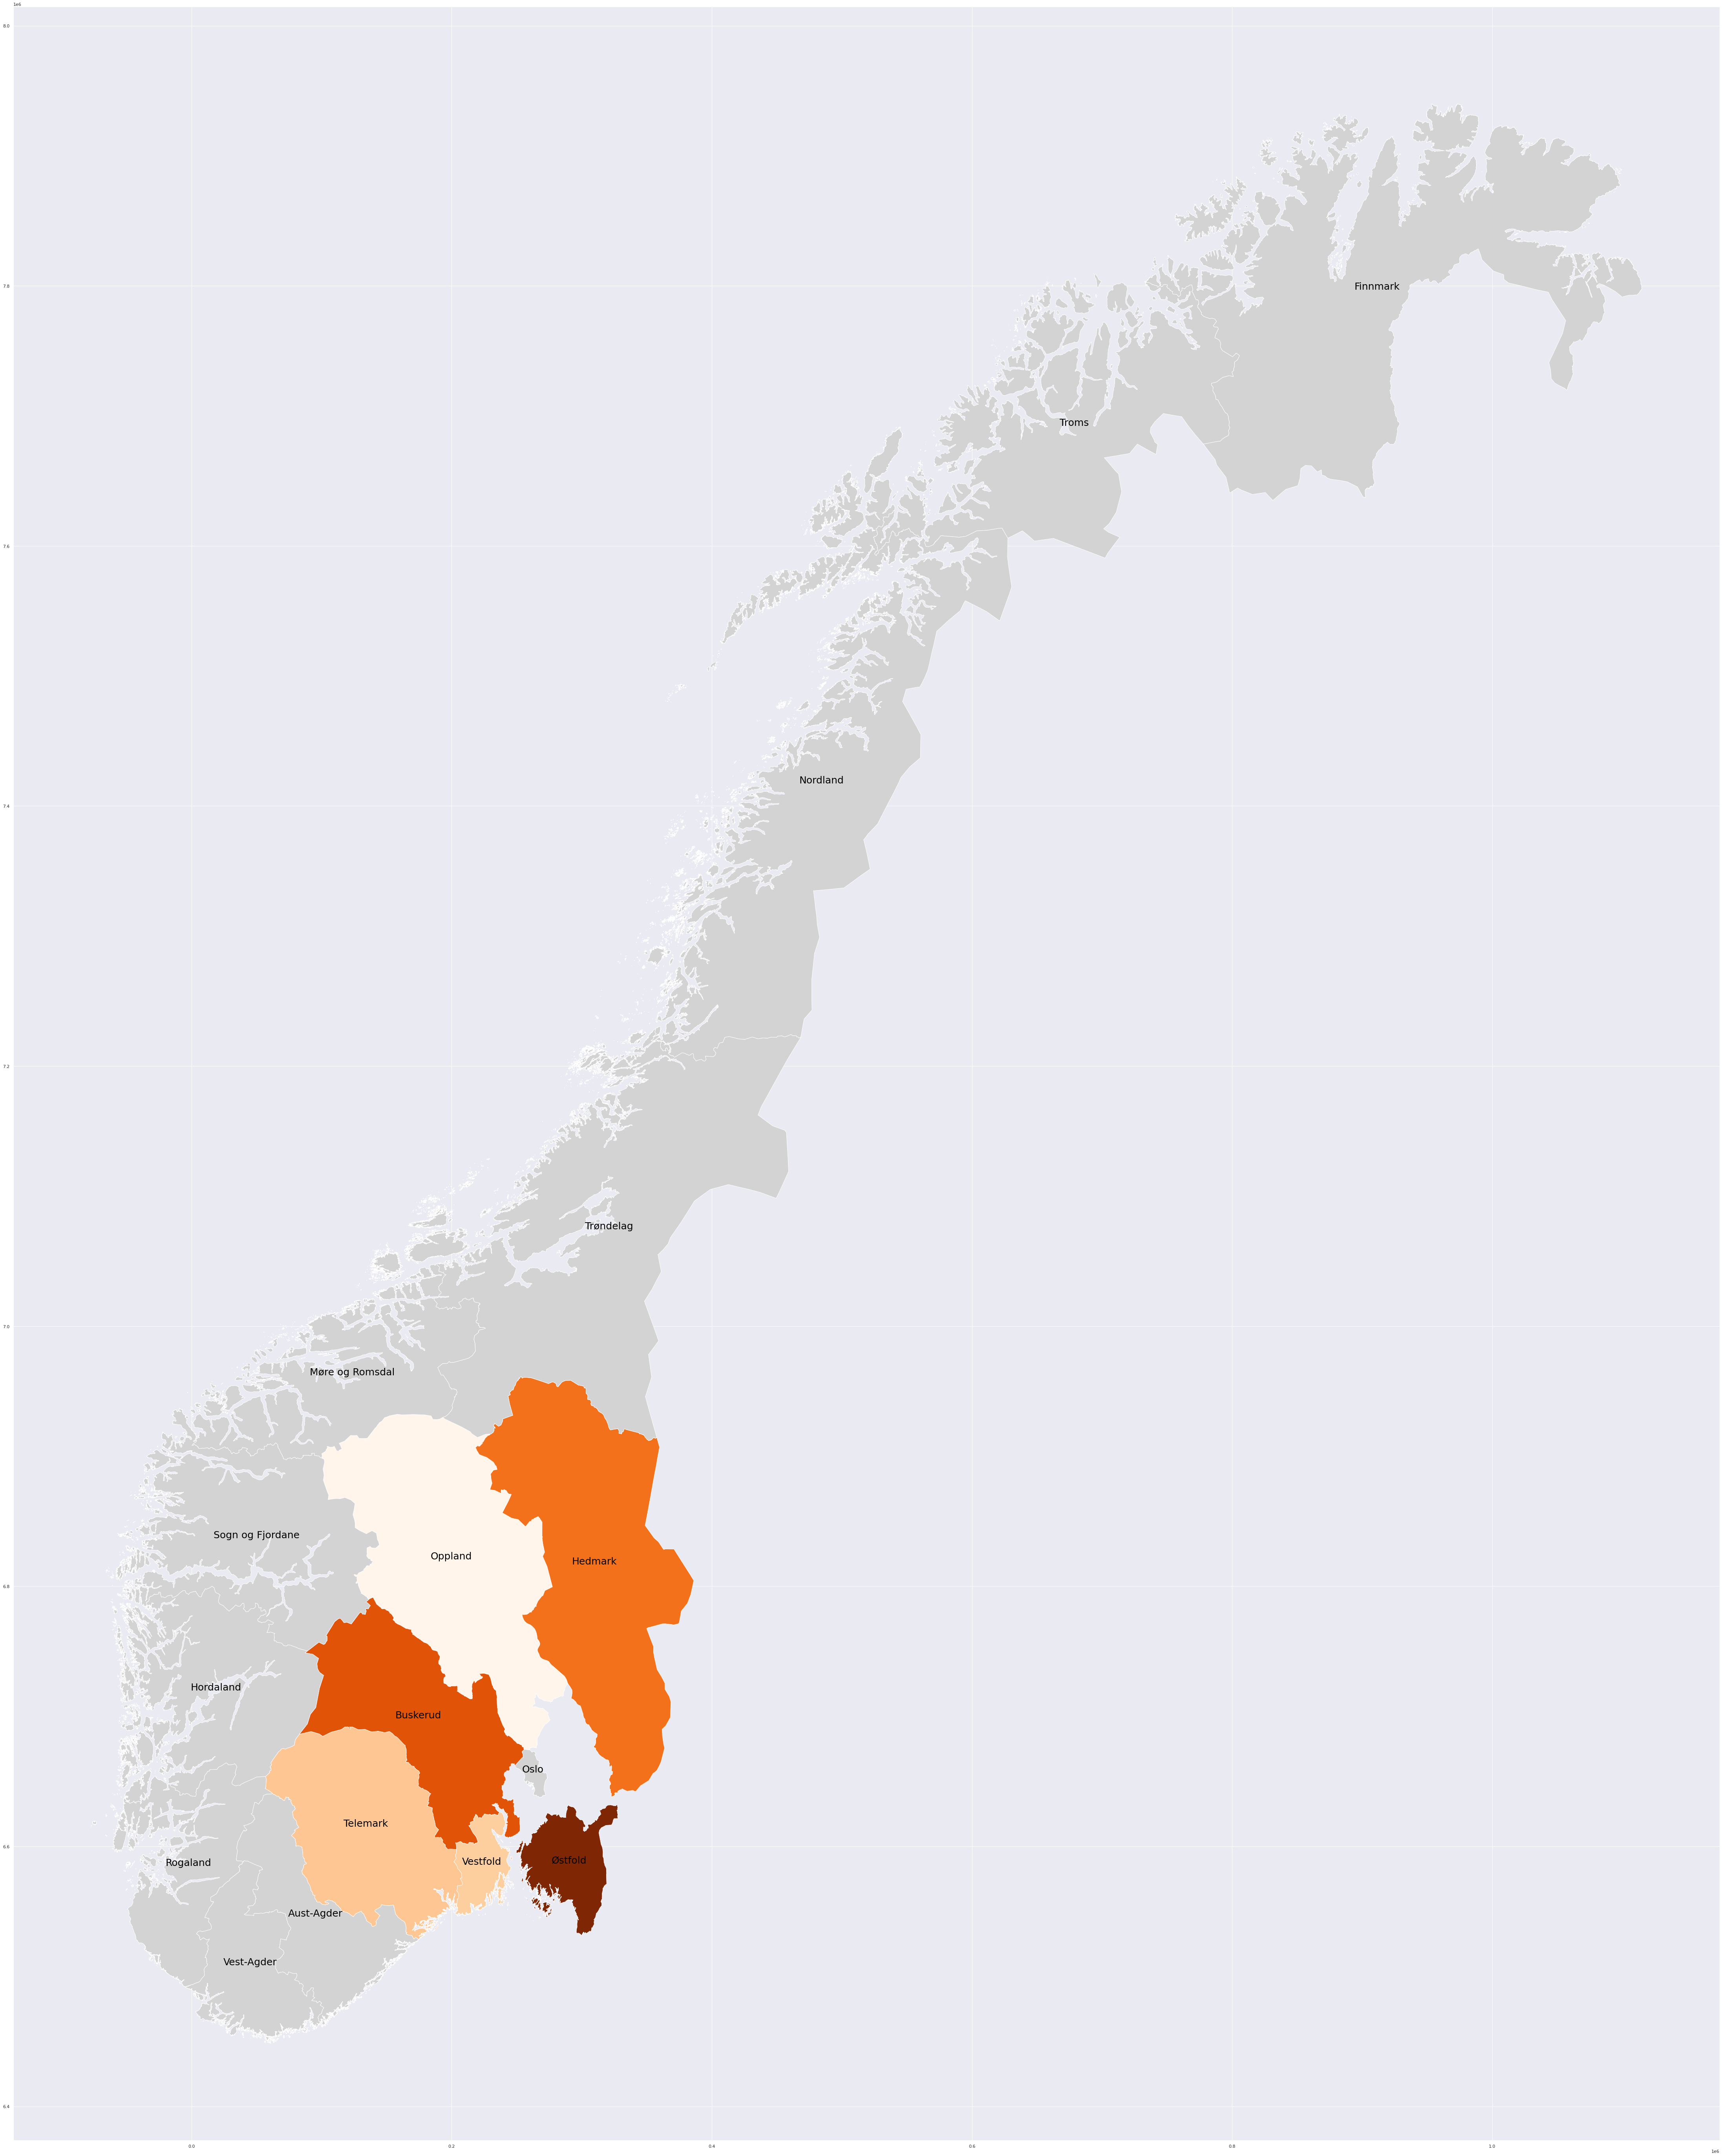

In [239]:
#@title Thirdly, we plot the total spend by county (excluding Akershus because it takes the greatest share)

# join county metrics with polygons
county_polygons = pd.merge(counties_2018, county , on='navn', how='left')
county_polygons = county_polygons[["navn", "geometry", "order_count","total_spend"]].sort_values(by=['total_spend'])

county_polygons_no_Akershus = county_polygons[county_polygons.navn != "Akershus"]
# plot
ax = county_polygons_no_Akershus.plot(column = "total_spend", figsize=(100, 100), cmap='Oranges', missing_kwds={'color': 'lightgrey'})
county_polygons_no_Akershus.apply(lambda x: ax.annotate(s=x.navn, xy=x.geometry.centroid.coords[0], ha='center', fontsize=25, color='black'),axis=1)
plt.show()

## 2. **...total spend on the municipality level during one year**

In [0]:
#@title Query to get total spend for each municipality

%%bigquery --project customers-behaviour municipality

WITH 

orders AS (
SELECT 
  order_id, 
  ANY_VALUE(zip_place) AS zip_place, 
  CAST(SUM(quantity*net_unit_price) AS INT64) AS order_total_spend
FROM
  `customers-behaviour.data.order_lines`
GROUP BY
  order_id), 

metrics_zip_place AS (

SELECT
  zip_place, 
  ANY_VALUE(municipality) AS municipality, 
  ANY_VALUE(county) AS county,
  COUNT(*) AS order_count, 
  SUM(order_total_spend) AS total_spend
FROM
  orders
LEFT JOIN
  `customers-behaviour.data.zip_places`
USING 
  (zip_place)
GROUP BY
  zip_place)

SELECT
ANY_VALUE(county) AS county,
municipality AS Kommunenav, 
SUM(order_count) AS order_count, 
SUM(total_spend) AS total_spend
FROM
metrics_zip_place
GROUP BY 
municipality
ORDER BY 
total_spend DESC

In [241]:
#@title  Municipalities based on their total spend per year
pd.set_option('display.max_rows', 2000)
municipality

county      Kommunenav  order_count  total_spend
0   Akershus             Ski        31612     33043806
1   Akershus           Bærum          752       849404
2   Akershus         Skedsmo          288       360937
3   Akershus           Asker          280       254628
4   Akershus       Lørenskog          251       237283
5    Østfold            Moss          195       179886
6   Akershus        Rælingen          195       167536
7   Akershus        Oppegård          121       143515
8   Akershus        Nittedal          167       134887
9    Hedmark       Ringsaker          124       112066
10  Akershus        Gjerdrum           79       108756
11  Telemark           Skien           82        95080
12  Buskerud          Røyken           47        90919
13  Akershus              Ås           59        75279
14  Akershus      Ullensaker           79        72669
15  Buskerud         Drammen           55        55510
16   Østfold     Fredrikstad           64        51058
17   Hedmark           Hamar           52        50432
18  Akershus        Eidsvoll           50        48719
19   Østfold       Sarpsborg           45        44544
20  Vestfold      Sandefjord           32        41253
21  Vestfold          Larvik           24        40073
22  Buskerud      Øvre Eiker           37        39458
23   Hedmark          Stange           36        37206
24  Akershus           Frogn           43        36526
25  Akershus             Fet           23        30439
26  Akershus        Nesodden           28        29982
27  Akershus          Vestby           16        23969
28  Akershus         Enebakk           24        23954
29  Akershus           Sørum           20        23395
30  Telemark       Porsgrunn           21        22375
31  Vestfold        Tønsberg           19        18810
32  Akershus             Nes           21        18208
33  Akershus  Aurskog-Høland           13        18099
34  Buskerud     Nedre Eiker           13        15460
35   Oppland     Lillehammer           13        14532
36   Østfold       Spydeberg           15        13196
37   Oppland        Jevnaker           12        12461
38  Buskerud            Hole            7        10943
39   Østfold           Askim           14        10860
40  Vestfold          Horten            8        10709
41  Buskerud       Kongsberg           10        10529
42   Oppland          Gjøvik           12        10047
43   Østfold           Rygge            5         6645
44  Buskerud            Lier            5         5524
45   Oppland    Vestre Toten            8         5025

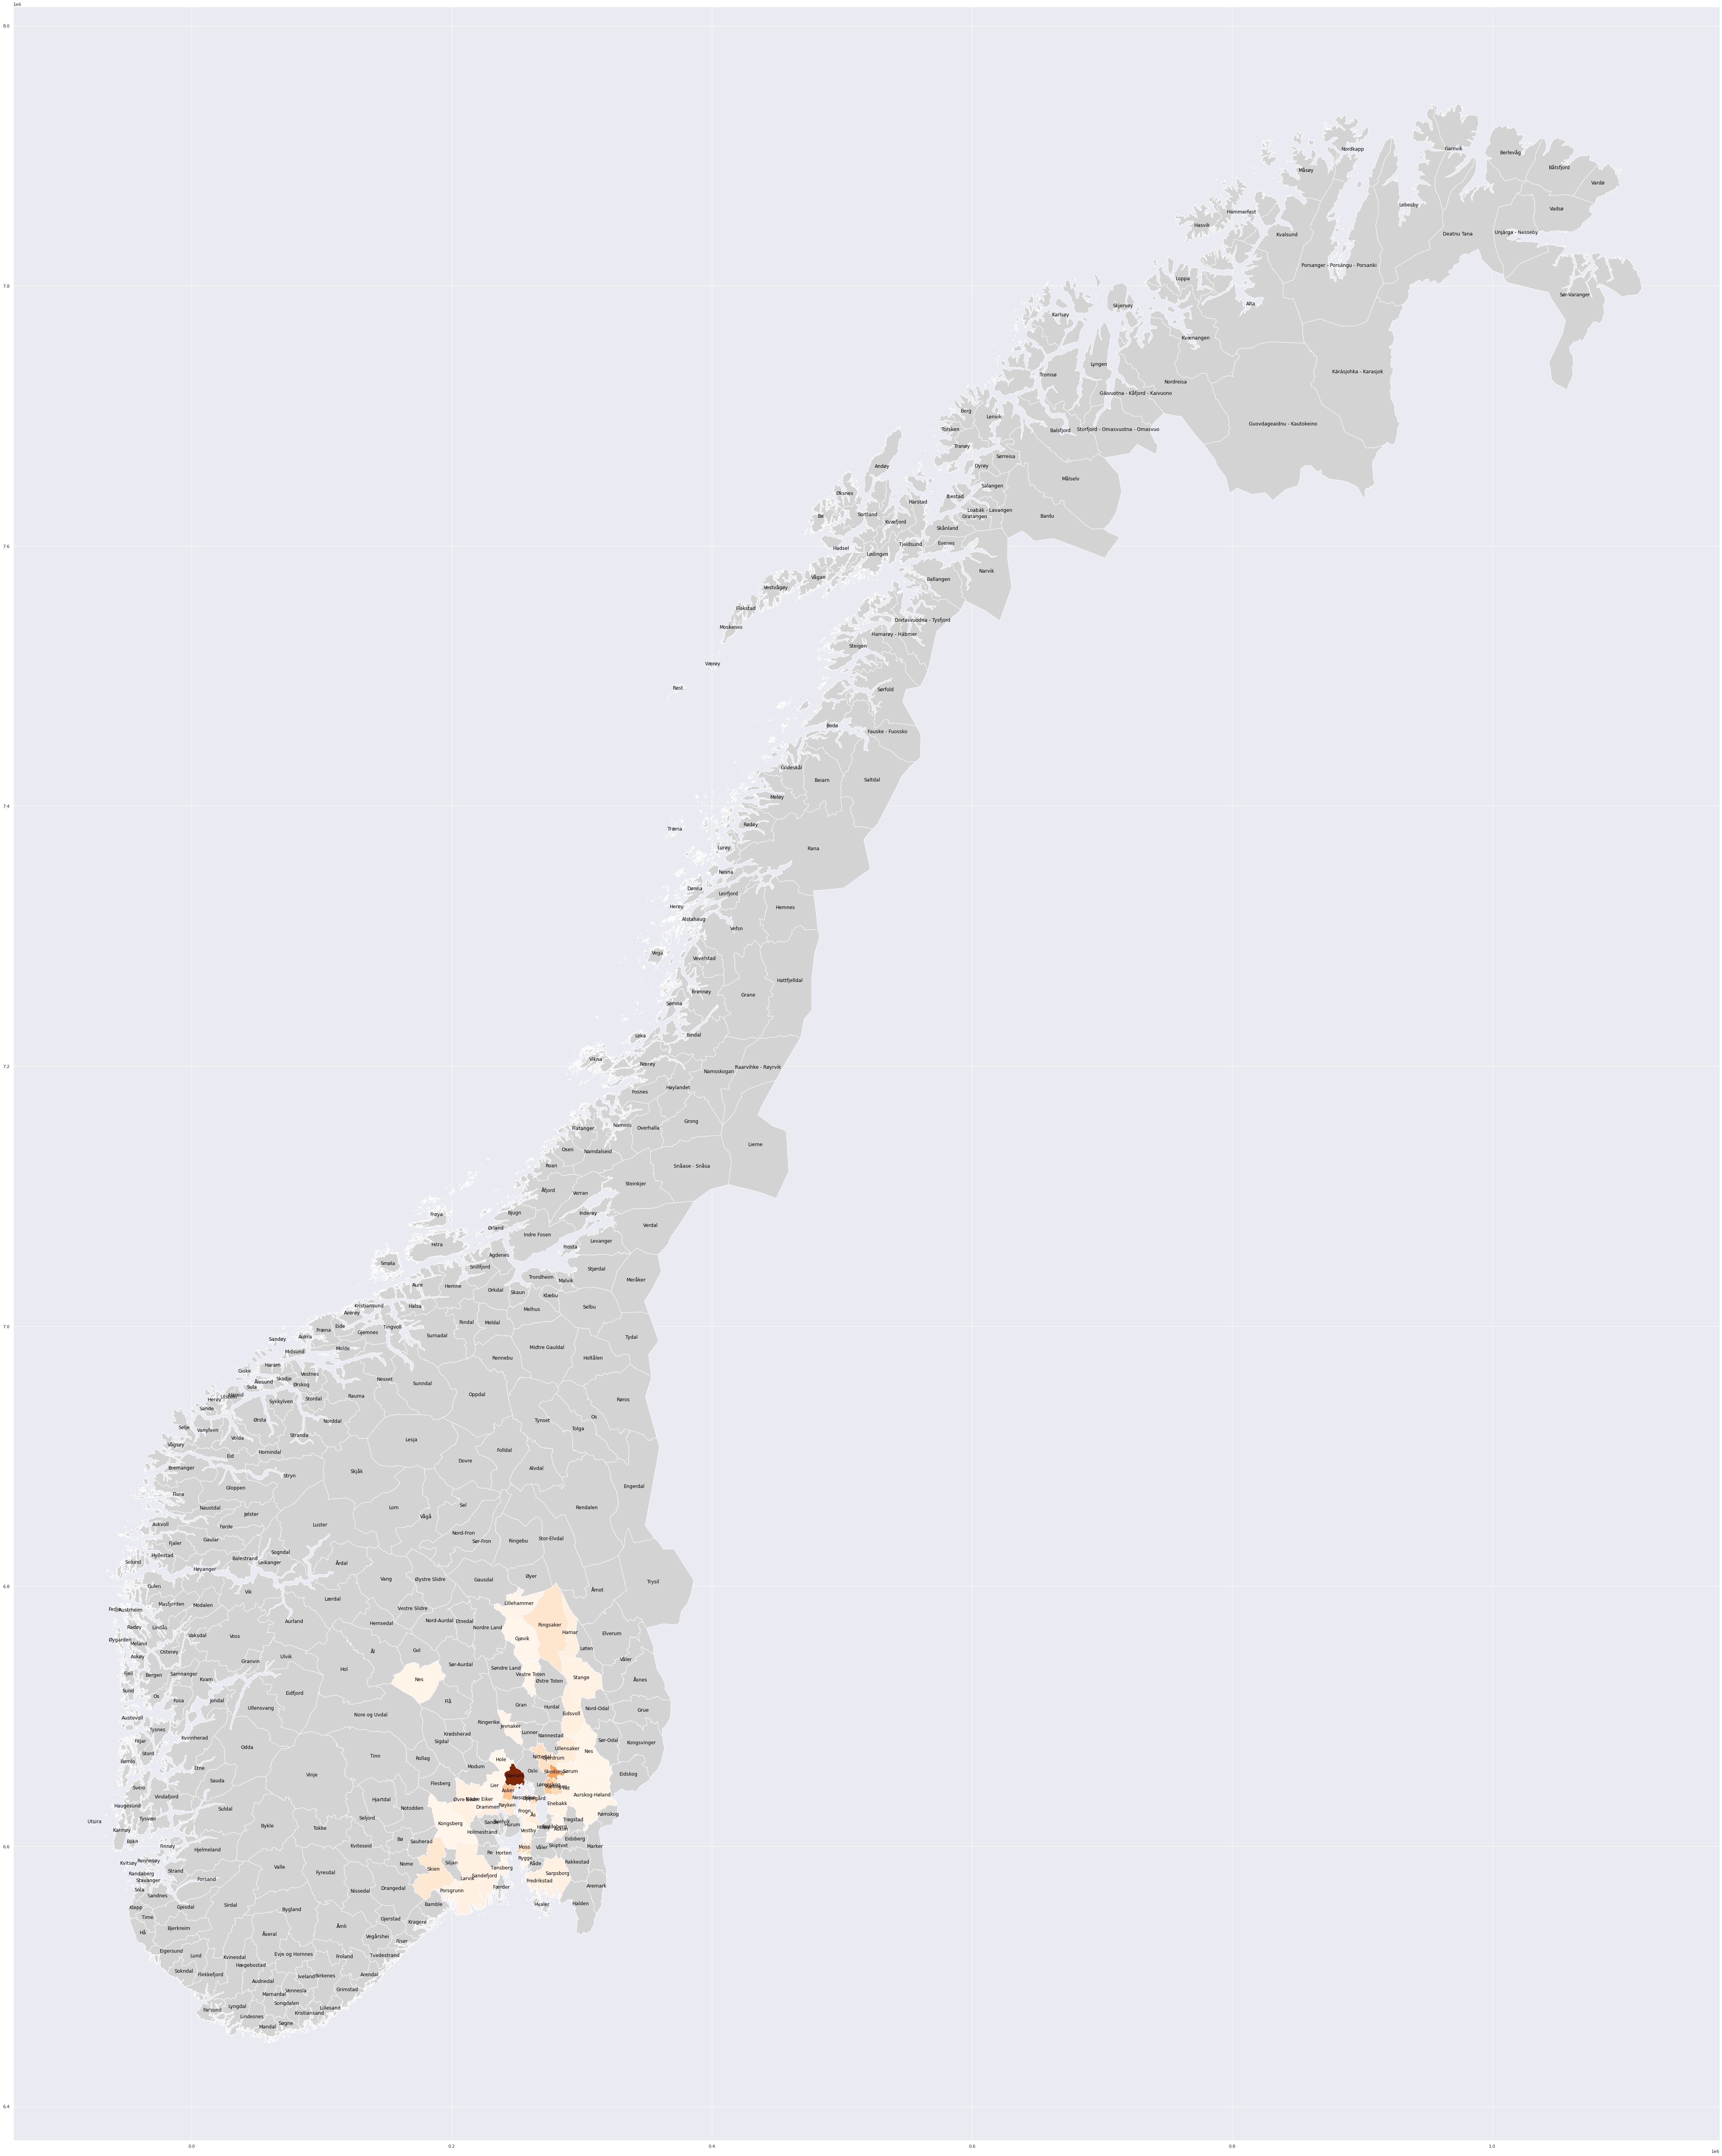

In [247]:
#@title Plotting the total spend by municipality (excluding Ski)


municipality_polygons = pd.merge(municipalities_2018, municipality , on='Kommunenav', how='left')
municipality_polygons = municipality_polygons[["Kommunenav", "geometry", "order_count","total_spend"]]

municipality_polygons.sort_values(by=['total_spend'])
municipality_polygons_no_ski = municipality_polygons[municipality_polygons.Kommunenav != "Ski"]
municipality_polygons_no_ski.sort_values(by=['total_spend'])

ax = municipality_polygons_no_ski.plot(column = "total_spend", figsize=(100, 100), cmap='Oranges', missing_kwds={'color': 'lightgrey'})
municipality_polygons_no_ski.apply(lambda x: ax.annotate(s=x.Kommunenav, xy=x.geometry.centroid.coords[0], ha='center', fontsize=12, color='black'),axis=1)
plt.show()